# Self-Explaining Neural Networks with Disentanglement
---

## Import libraries

In [3]:
import sys
sys.path.append('..')

In [4]:
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path
from types import SimpleNamespace
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
from models.losses import *
from models.parameterizer import ConvParameterizer
from models.conceptizer import ConvConceptizer, VaeConceptizer
from models.aggregator import SumAggregator

## Configuration

In [6]:
plt.style.use('seaborn-paper')

In [7]:
config = {"model_class": "DiSENN",
          "conceptizer": "VaeConceptizer",
          "beta": 1.0,
          "concept_loss": "BVAE_loss",
          "robustness_loss": "mnist_robustness_loss",
          "image_size": 28,
          "concept_dim": 1,
          "concept_visualization": "activation",
          "parameterizer": "ConvParameterizer",
          "cl_sizes": [1, 10, 20],
          "hidden_sizes": [320, 50],
          "num_concepts": 5,
          "num_classes": 10,
          "dropout": 0.5,
          "aggregator": "SumAggregator",
          "device": "cpu",
          "exp_name": "test_mnist_bvae",
          "dataloader": "mnist",
          "data_path": "datasets/data/mnist_data",
          "batch_size" : 16}
config = SimpleNamespace(**config)

## DiSENN
DiSENN (Self-Explaining Neural Networks with Disentanglement) is an extension of the Self-Explaining Neural Network proposed by [1]  

DiSENN incorporates a constrained variational inference framework on a 
SENN Concept Encoder to learn disentangled representations of the 
basis concepts as in [2]. The basis concepts are then independently
sensitive to single generative factors leading to better interpretability 
and lesser overlap with other basis concepts. Such a strong constraint 
better fulfills the "diversity" desiderata for basis concepts
in a Self-Explaining Neural Network.


References  
[1] Alvarez Melis, et al.
"Towards Robust Interpretability with Self-Explaining Neural Networks" NIPS 2018  
[2] Irina Higgins, et al. 
”β-VAE: Learning basic visual concepts with a constrained variational framework.” ICLR 2017. 

In [11]:
class DiSENN(nn.Module):
    """Self-Explaining Neural Network with Disentanglement """
    
    def __init__(self, vae_conceptizer, parameterizer, aggregator):
        """Instantiates the SENDD with a variational conceptizer, parameterizer and aggregator"""
        super().__init__()
        self.vae_conceptizer = vae_conceptizer
        self.parameterizer = parameterizer
        self.aggregator = aggregator

    def forward(self, x):
        """Forward pass of a DiSENN model
        
        The forward pass computes a distribution over basis concepts
        and the corresponding relevance scores. The mean concepts 
        and relevance scores are aggregated to generate a prediction.
        """
        concept_mean, concept_logvar, x_reconstruct = self.vae_conceptizer(x)
        relevances = self.parameterizer(x)
        predictions = self.aggregator(concept_mean, relevances)
        explanations = ((concept_mean, concept_logvar), relevances)
        return predictions, explanations, x_reconstruct

## Load Data

In [10]:
from datasets.dataloaders import get_dataloader
train_dl, val_dl, _ = get_dataloader(config)

## Load Trained Model

In [12]:
conceptizer = eval(config.conceptizer)(**config.__dict__)
parameterizer = eval(config.parameterizer)(**config.__dict__)
aggregator = eval(config.aggregator)(**config.__dict__)

In [13]:
model = DiSENN(conceptizer, parameterizer, aggregator)

In [15]:
checkpoint_path = Path('../results')
model_file = checkpoint_path / config.exp_name / "checkpoints" / "best_model.pt" 
checkpoint = torch.load(model_file, config.device)
print(f"Loading trained model: {model_file}")

Loading trained model: ../results/test_mnist_bvae/checkpoints/best_model.pt


In [16]:
model.load_state_dict(checkpoint['model_state'])

<All keys matched successfully>

## Classification

In [17]:
xb, yb = next(iter(val_dl))
y_pred, explanations, x_reconstruct = model(xb)

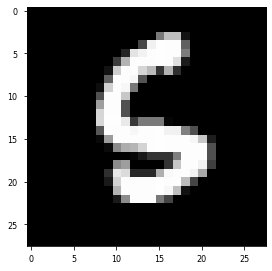

In [18]:
plt.imshow(xb[-1][0], cmap='gray')

In [19]:
y_pred.argmax(1), yb

(tensor([5, 9, 5, 5, 8, 4, 4, 7, 4, 6, 7, 1, 1, 5, 8, 5]),
 tensor([5, 9, 9, 5, 8, 4, 8, 0, 8, 6, 7, 1, 1, 5, 5, 5]))

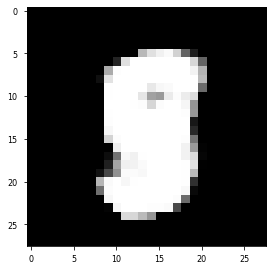

In [20]:
plt.imshow(x_reconstruct[-1][0].detach().numpy(), cmap='gray')

In [21]:
accuracy = 0.
model.eval()
with torch.no_grad():
    for i, (x, labels) in enumerate(val_dl):
        x = x.float().to(config.device)
        labels = labels.long().to(config.device)
        y_pred, explanations, x_reconstructed = model(x)
        accuracy += (y_pred.argmax(axis=1) == labels).float().mean().item()
print(f"Test Mean Accuracy: {accuracy/i*100:.3f} %")

Test Mean Accuracy: 94.552 %


## Explanation

### Generate Prototypes from Disentangled Concepts

In [22]:
num_prototypes = 10
traversal_range = 2

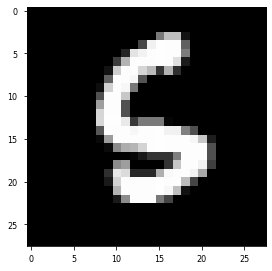

In [23]:
x = xb[-1]
plt.imshow(x.numpy().squeeze(), cmap='gray')

In [24]:
x_posterior_mean, x_posterior_logvar = model.vae_conceptizer.encoder(x)

In [25]:
concepts = x_posterior_mean.detach().numpy()
num_concepts = concepts.shape[1]
concepts_sample = model.vae_conceptizer.sample(x_posterior_mean, x_posterior_logvar).detach()

In [26]:
concepts_sample = concepts_sample.repeat(num_prototypes, 1)

In [27]:
concepts_sample

tensor([[-0.3503,  0.3056, -0.0825,  0.1674, -0.5117],
        [-0.3503,  0.3056, -0.0825,  0.1674, -0.5117],
        [-0.3503,  0.3056, -0.0825,  0.1674, -0.5117],
        [-0.3503,  0.3056, -0.0825,  0.1674, -0.5117],
        [-0.3503,  0.3056, -0.0825,  0.1674, -0.5117],
        [-0.3503,  0.3056, -0.0825,  0.1674, -0.5117],
        [-0.3503,  0.3056, -0.0825,  0.1674, -0.5117],
        [-0.3503,  0.3056, -0.0825,  0.1674, -0.5117],
        [-0.3503,  0.3056, -0.0825,  0.1674, -0.5117],
        [-0.3503,  0.3056, -0.0825,  0.1674, -0.5117]])

In [28]:
def independent_traversal(matrix, dim, traversal_range=2, steps=num_prototypes):
    """Linearly traverses through one dimension of a matrix independently"""
    traversal = torch.linspace(-1 * traversal_range, traversal_range, steps)
    matrix_traversal = matrix.clone() # to avoid changing the matrix
    matrix_traversal[:, dim] = traversal
    return matrix_traversal

In [29]:
concepts_traversals = [independent_traversal(concepts_sample, dim) for dim in range(num_concepts)]

In [30]:
concepts_traversals[2]

tensor([[-0.3503,  0.3056, -2.0000,  0.1674, -0.5117],
        [-0.3503,  0.3056, -1.5556,  0.1674, -0.5117],
        [-0.3503,  0.3056, -1.1111,  0.1674, -0.5117],
        [-0.3503,  0.3056, -0.6667,  0.1674, -0.5117],
        [-0.3503,  0.3056, -0.2222,  0.1674, -0.5117],
        [-0.3503,  0.3056,  0.2222,  0.1674, -0.5117],
        [-0.3503,  0.3056,  0.6667,  0.1674, -0.5117],
        [-0.3503,  0.3056,  1.1111,  0.1674, -0.5117],
        [-0.3503,  0.3056,  1.5556,  0.1674, -0.5117],
        [-0.3503,  0.3056,  2.0000,  0.1674, -0.5117]])

In [31]:
concepts_traversals = torch.cat(concepts_traversals, dim=0)

In [32]:
prototypes = model.vae_conceptizer.decoder(concepts_traversals)

In [33]:
prototypes.shape

torch.Size([50, 784])

In [34]:
prototype_imgs = prototypes.view((-1, 1, 28, 28))

In [35]:
prototype_imgs.shape

torch.Size([50, 1, 28, 28])

In [36]:
from torchvision.utils import make_grid

In [37]:
# nrow is number of images in a row which must be the number of prototypes
prototype_grid_img = make_grid(prototype_imgs, nrow=num_prototypes).detach().numpy()

In [38]:
prototype_grid_img.shape

(3, 152, 302)

<BarContainer object of 5 artists>

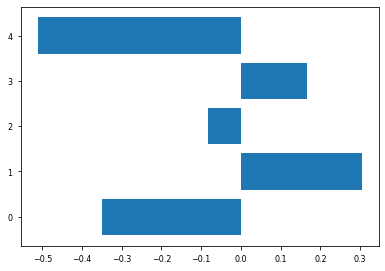

In [39]:
plt.barh(range(num_concepts), concepts.squeeze())

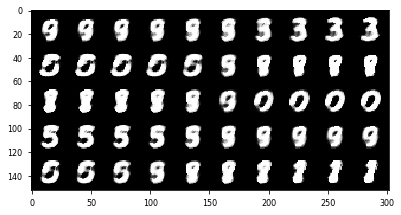

In [40]:
plt.imshow(prototype_grid_img.transpose(1,2,0))

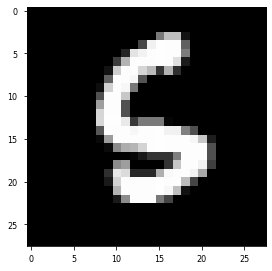

In [41]:
plt.imshow(x.numpy().squeeze(), cmap='gray')